In [1]:
import arxivscraper as ax

In [2]:
scraper = ax.Scraper(category='cs',date_from='1993-08-01',date_until='2018-12-31',t=10)#, filters={'categories':['stat.ml']})
output_cs = scraper.scrape()

http://export.arxiv.org/oai2?verb=ListRecords&from=1993-08-01&until=2018-12-31&metadataPrefix=arXiv&set=cs
fetching up to  1000 records...
fetching up to  2000 records...
fetching up to  3000 records...
fetching up to  4000 records...
fetching up to  5000 records...
fetching up to  6000 records...
fetching up to  7000 records...
fetching up to  8000 records...
fetching up to  9000 records...
fetching up to  10000 records...
fetching up to  11000 records...
fetching up to  12000 records...
fetching up to  13000 records...
fetching up to  14000 records...
fetching up to  15000 records...
fetching up to  16000 records...
fetching up to  17000 records...
fetching up to  18000 records...
fetching up to  19000 records...
fetching up to  20000 records...
fetching up to  21000 records...
fetching up to  22000 records...
fetching up to  23000 records...
fetching up to  24000 records...
fetching up to  25000 records...
fetching up to  26000 records...
fetching up to  27000 records...
fetching up

In [3]:
import pandas as pd
cols = ('id', 'title', 'categories', 'abstract', 'doi', 'created', 'updated', 'authors')

In [4]:
df_cs = pd.DataFrame(output_cs,columns=cols)

In [5]:
df_cs.to_pickle('cs.pkl') # :D

# Category network!

In [9]:
import pickle
import numpy as np

df_cs=pickle.load(open('cs.pkl','rb'))

In [3]:
categories_cs = [text for text in df_cs.categories]

In [4]:
categories_cs[0]

'math.co cs.cg'

In [5]:
time_cs = [t[:4] for t in df_cs.created]
years_cs = sorted(list(set(time_cs)))

In [28]:
categories_cs_year={year:[] for year in years_cs}
for i in range(len(categories_cs)):
    categories_cs_year[time_cs[i]]+=[categories_cs[i]]

In [29]:
categories_cs_year['1992']

['cs.ds math.co']

## network construction!

In [89]:
## graph by year
import networkx as nx
import itertools

def graph_weighted(list_categories,cs=False):
    G=nx.Graph()
    for cat in list_categories:
        if len(cat.split(' '))>1:
            if cs==True: ## only cs categories!
                pairs=list(itertools.combinations([x for x in cat.split(' ') if x.startswith('cs')], 2))
            elif cs==False:
                pairs=list(itertools.combinations(cat.split(' '), 2))
            for pair in pairs:
                a=pair[0]
                b=pair[1]
                if G.has_edge(a,b)==False:
                    G.add_edge(a,b,weight=1)
                else:
                    x=G[a][b]['weight']
                    G[a][b]['weight']=x+1
    
    return G

In [90]:
networks={}
for year in years_cs:
    networks[year]=graph_weighted(categories_cs_year[year])
    
networks_cs={}
for year in years_cs:
    networks_cs[year]=graph_weighted(categories_cs_year[year],True)

In [92]:
networks_cs['1999'].nodes()

NodeView(('cs.lg', 'cs.ai', 'cs.lo', 'cs.ir', 'cs.cg', 'cs.db', 'cs.ds', 'cs.sc', 'cs.pl', 'cs.ms', 'cs.ce', 'cs.cc', 'cs.it', 'cs.dl', 'cs.cl', 'cs.dc', 'cs.dm', 'cs.ne', 'cs.ma', 'cs.hc', 'cs.pf', 'cs.se', 'cs.os', 'cs.ar', 'cs.ni', 'cs.cy', 'cs.na', 'cs.gl', 'cs.cv', 'cs.cr', 'cs.gr', 'cs.fl'))

In [93]:
import pickle

pickle.dump(networks, open('networks.p', 'wb'))
pickle.dump(networks_cs, open('networks_cs.p', 'wb'))

In [7]:
import pickle

networks=pickle.load(open('networks.p','rb'))
networks_cs=pickle.load(open('networks_cs.p','rb'))

## Core diversity!

In [119]:
diversity_core={}
diversity_crust={}

for year in years_cs:
    try:
        try:
            N=nx.k_core(networks[year])
            diversity_core[year]=len([node for node in N.nodes() if node.startswith('cs')])/float(len(N))
            
            M=nx.k_crust(networks[year])
            diversity_crust[year]=len([node for node in M.nodes() if node.startswith('cs')])/float(len(M))
        except ValueError:
            pass
    except ZeroDivisionError:
        pass

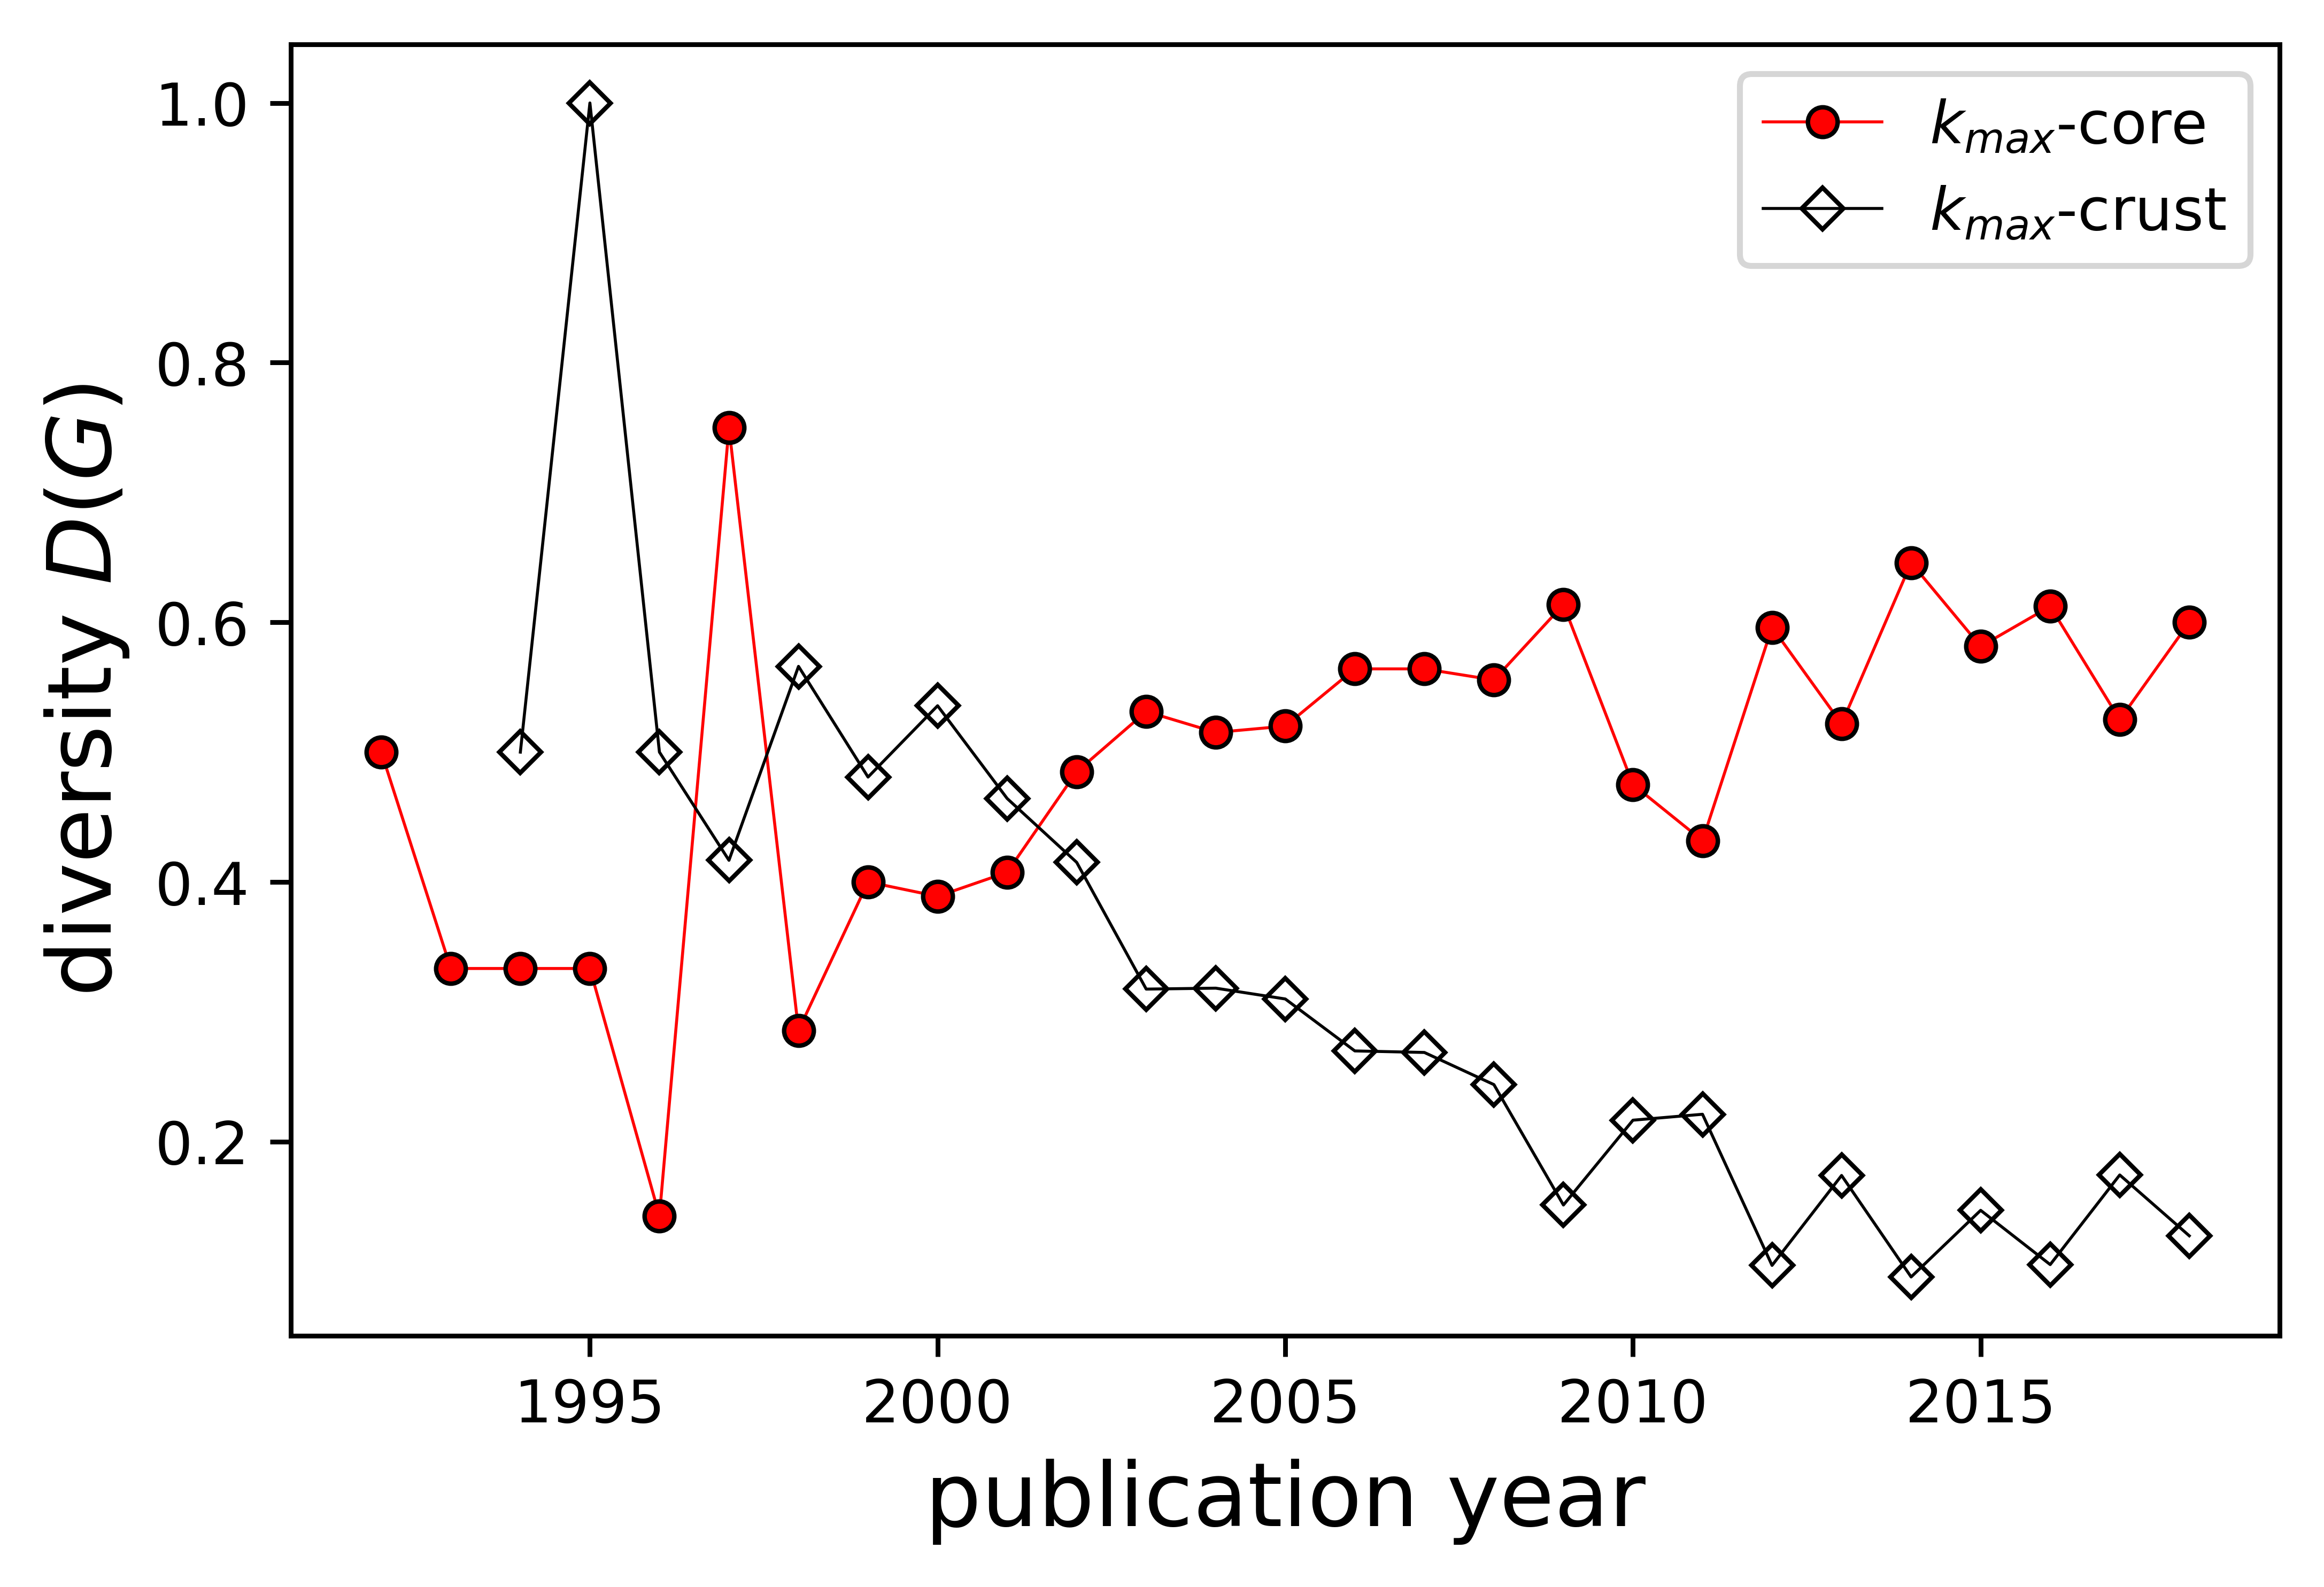

In [148]:
## plot
import matplotlib.pyplot as plt

X=[int(y) for y in list(diversity_core.keys())]
Y=list(diversity_core.values())

x=[int(y) for y in list(diversity_crust.keys())]
y=list(diversity_crust.values())

fig, ax = plt.subplots(dpi=800)
ax.plot(X,Y, 'r',marker='o',markeredgecolor='k',markersize=5,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label=r'$k_{max}$-core')
ax.plot(x,y, 'k',marker='D',markeredgecolor='k',markersize=5,fillstyle='none',markeredgewidth=.75,clip_on=True,linewidth=0.5,label=r'$k_{max}$-crust')

ax.legend(loc='best')
ax.grid(False)
plt.ylabel(r'diversity $D(G)$',fontsize=15)
plt.xlabel(r'publication year',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('diversity.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [137]:
diversity_years={}
for year in years_cs:
    D={}
    cores=set(nx.core_number(networks[year]).values())
    for k in cores:
        N=nx.k_core(networks[year],k=k)
        D[k]=len([node for node in N.nodes() if node.startswith('cs')])/float(len(N))
    diversity_years[year]=D

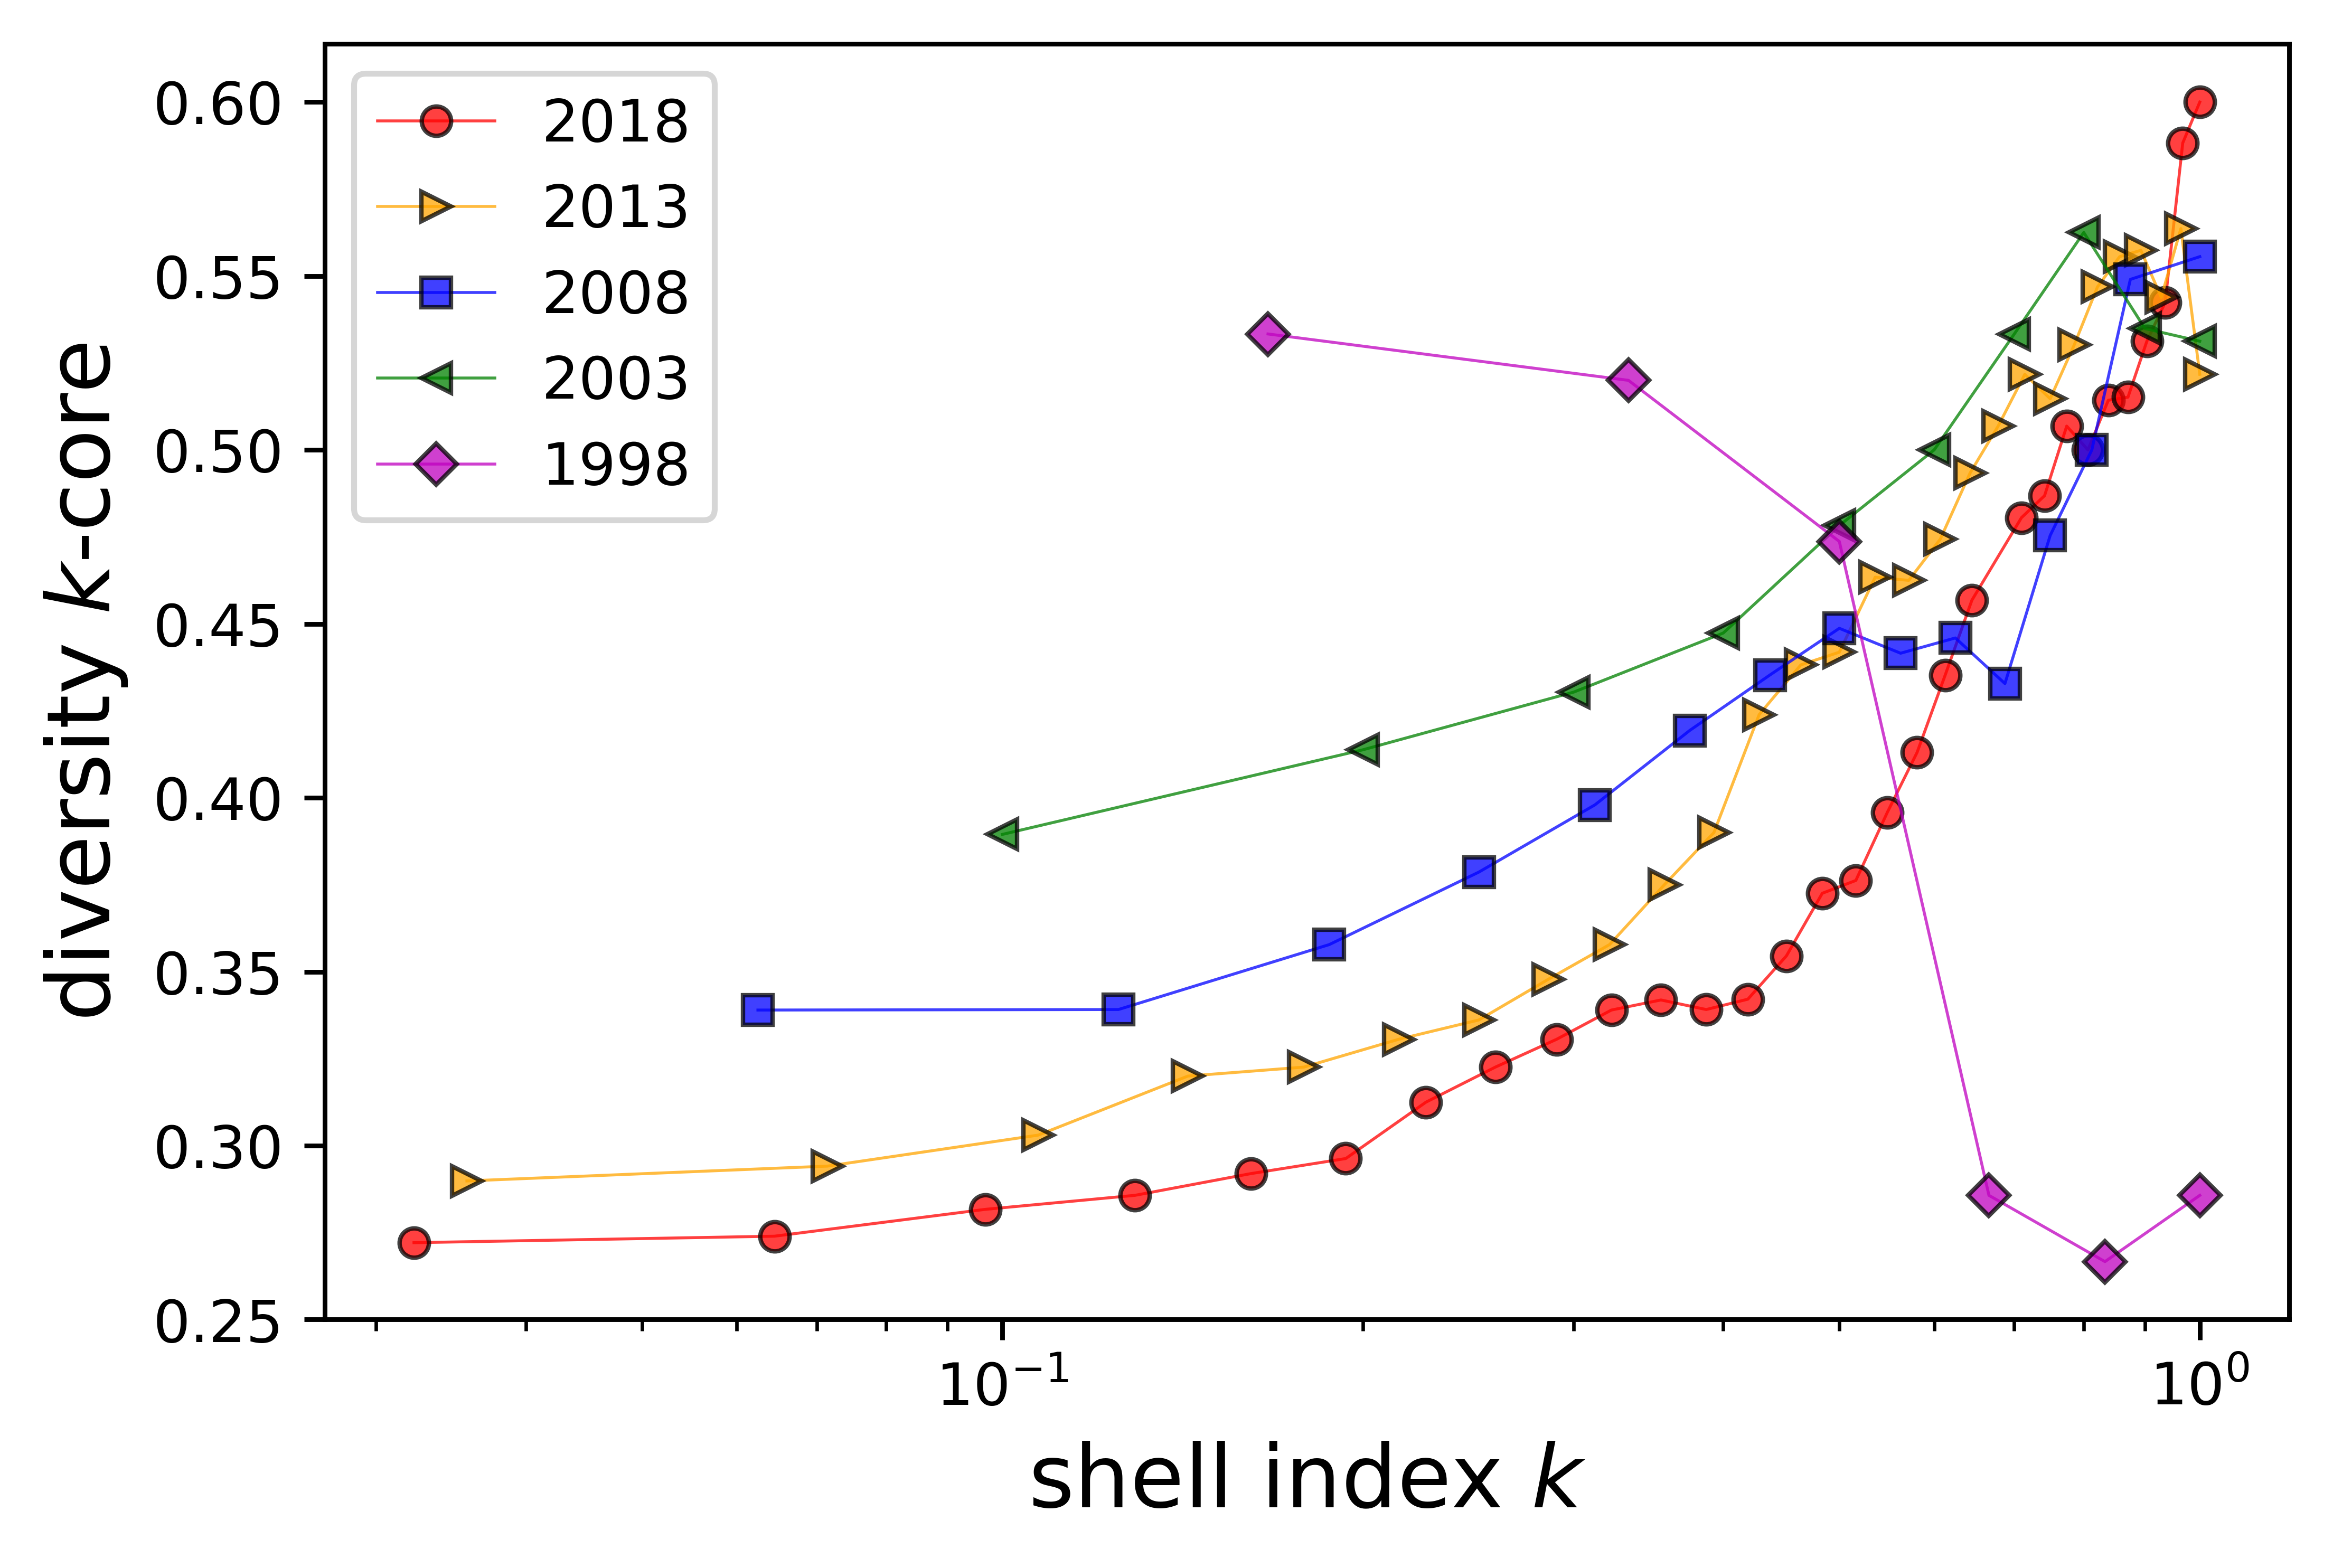

In [146]:
## plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=800)
ax.semilogx([x/float(max(diversity_years['2018'].keys())) for x in diversity_years['2018'].keys()],diversity_years['2018'].values(), 'r',marker='o',alpha=0.75,markeredgecolor='k',markersize=5,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='2018')
ax.semilogx([x/float(max(diversity_years['2013'].keys())) for x in diversity_years['2013'].keys()],diversity_years['2013'].values(), 'orange',marker='>',alpha=0.75,markeredgecolor='k',markersize=5,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='2013')
ax.semilogx([x/float(max(diversity_years['2008'].keys())) for x in diversity_years['2008'].keys()],diversity_years['2008'].values(), 'b',marker='s',alpha=0.75,markeredgecolor='k',markersize=5,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='2008')
ax.semilogx([x/float(max(diversity_years['2003'].keys())) for x in diversity_years['2003'].keys()],diversity_years['2003'].values(), 'green',marker='<',alpha=0.75,markeredgecolor='k',markersize=5,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='2003')
ax.semilogx([x/float(max(diversity_years['1998'].keys())) for x in diversity_years['1998'].keys()],diversity_years['1998'].values(), 'm',marker='D',alpha=0.75,markeredgecolor='k',markersize=5,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='1998')

#ax.plot(x_cs,y_cs, 'k',marker='o',markeredgecolor='k',markersize=6,fillstyle='none',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='only cs categories')

ax.legend(loc='best')
ax.grid(False)
plt.ylabel(r'diversity $k$-core',fontsize=15)
plt.xlabel(r'shell index $k$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('diversity_years.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

## average degree

In [10]:
average_degree={}
random_year={}
len_G={}
for year in years_cs:
    G=networks[year]
    if len(G)>1:
        deg=np.mean(list(dict(G.degree(weight='none')).values()))
        #random_year[year]=nx.watts_strogatz_graph(len(G),int(deg),1)
        average_degree[year]=deg
        len_G[year]=len(G)
        
average_degree_cs={}
random_year_cs={}
len_G_cs={}
for year in years_cs:
    G=networks_cs[year]
    if len(G)>1:
        deg=np.mean(list(dict(G.degree(weight='none')).values()))
        #random_year_cs[year]=nx.watts_strogatz_graph(len(G),int(deg),1)
        average_degree_cs[year]=deg
        len_G_cs[year]=len(G)

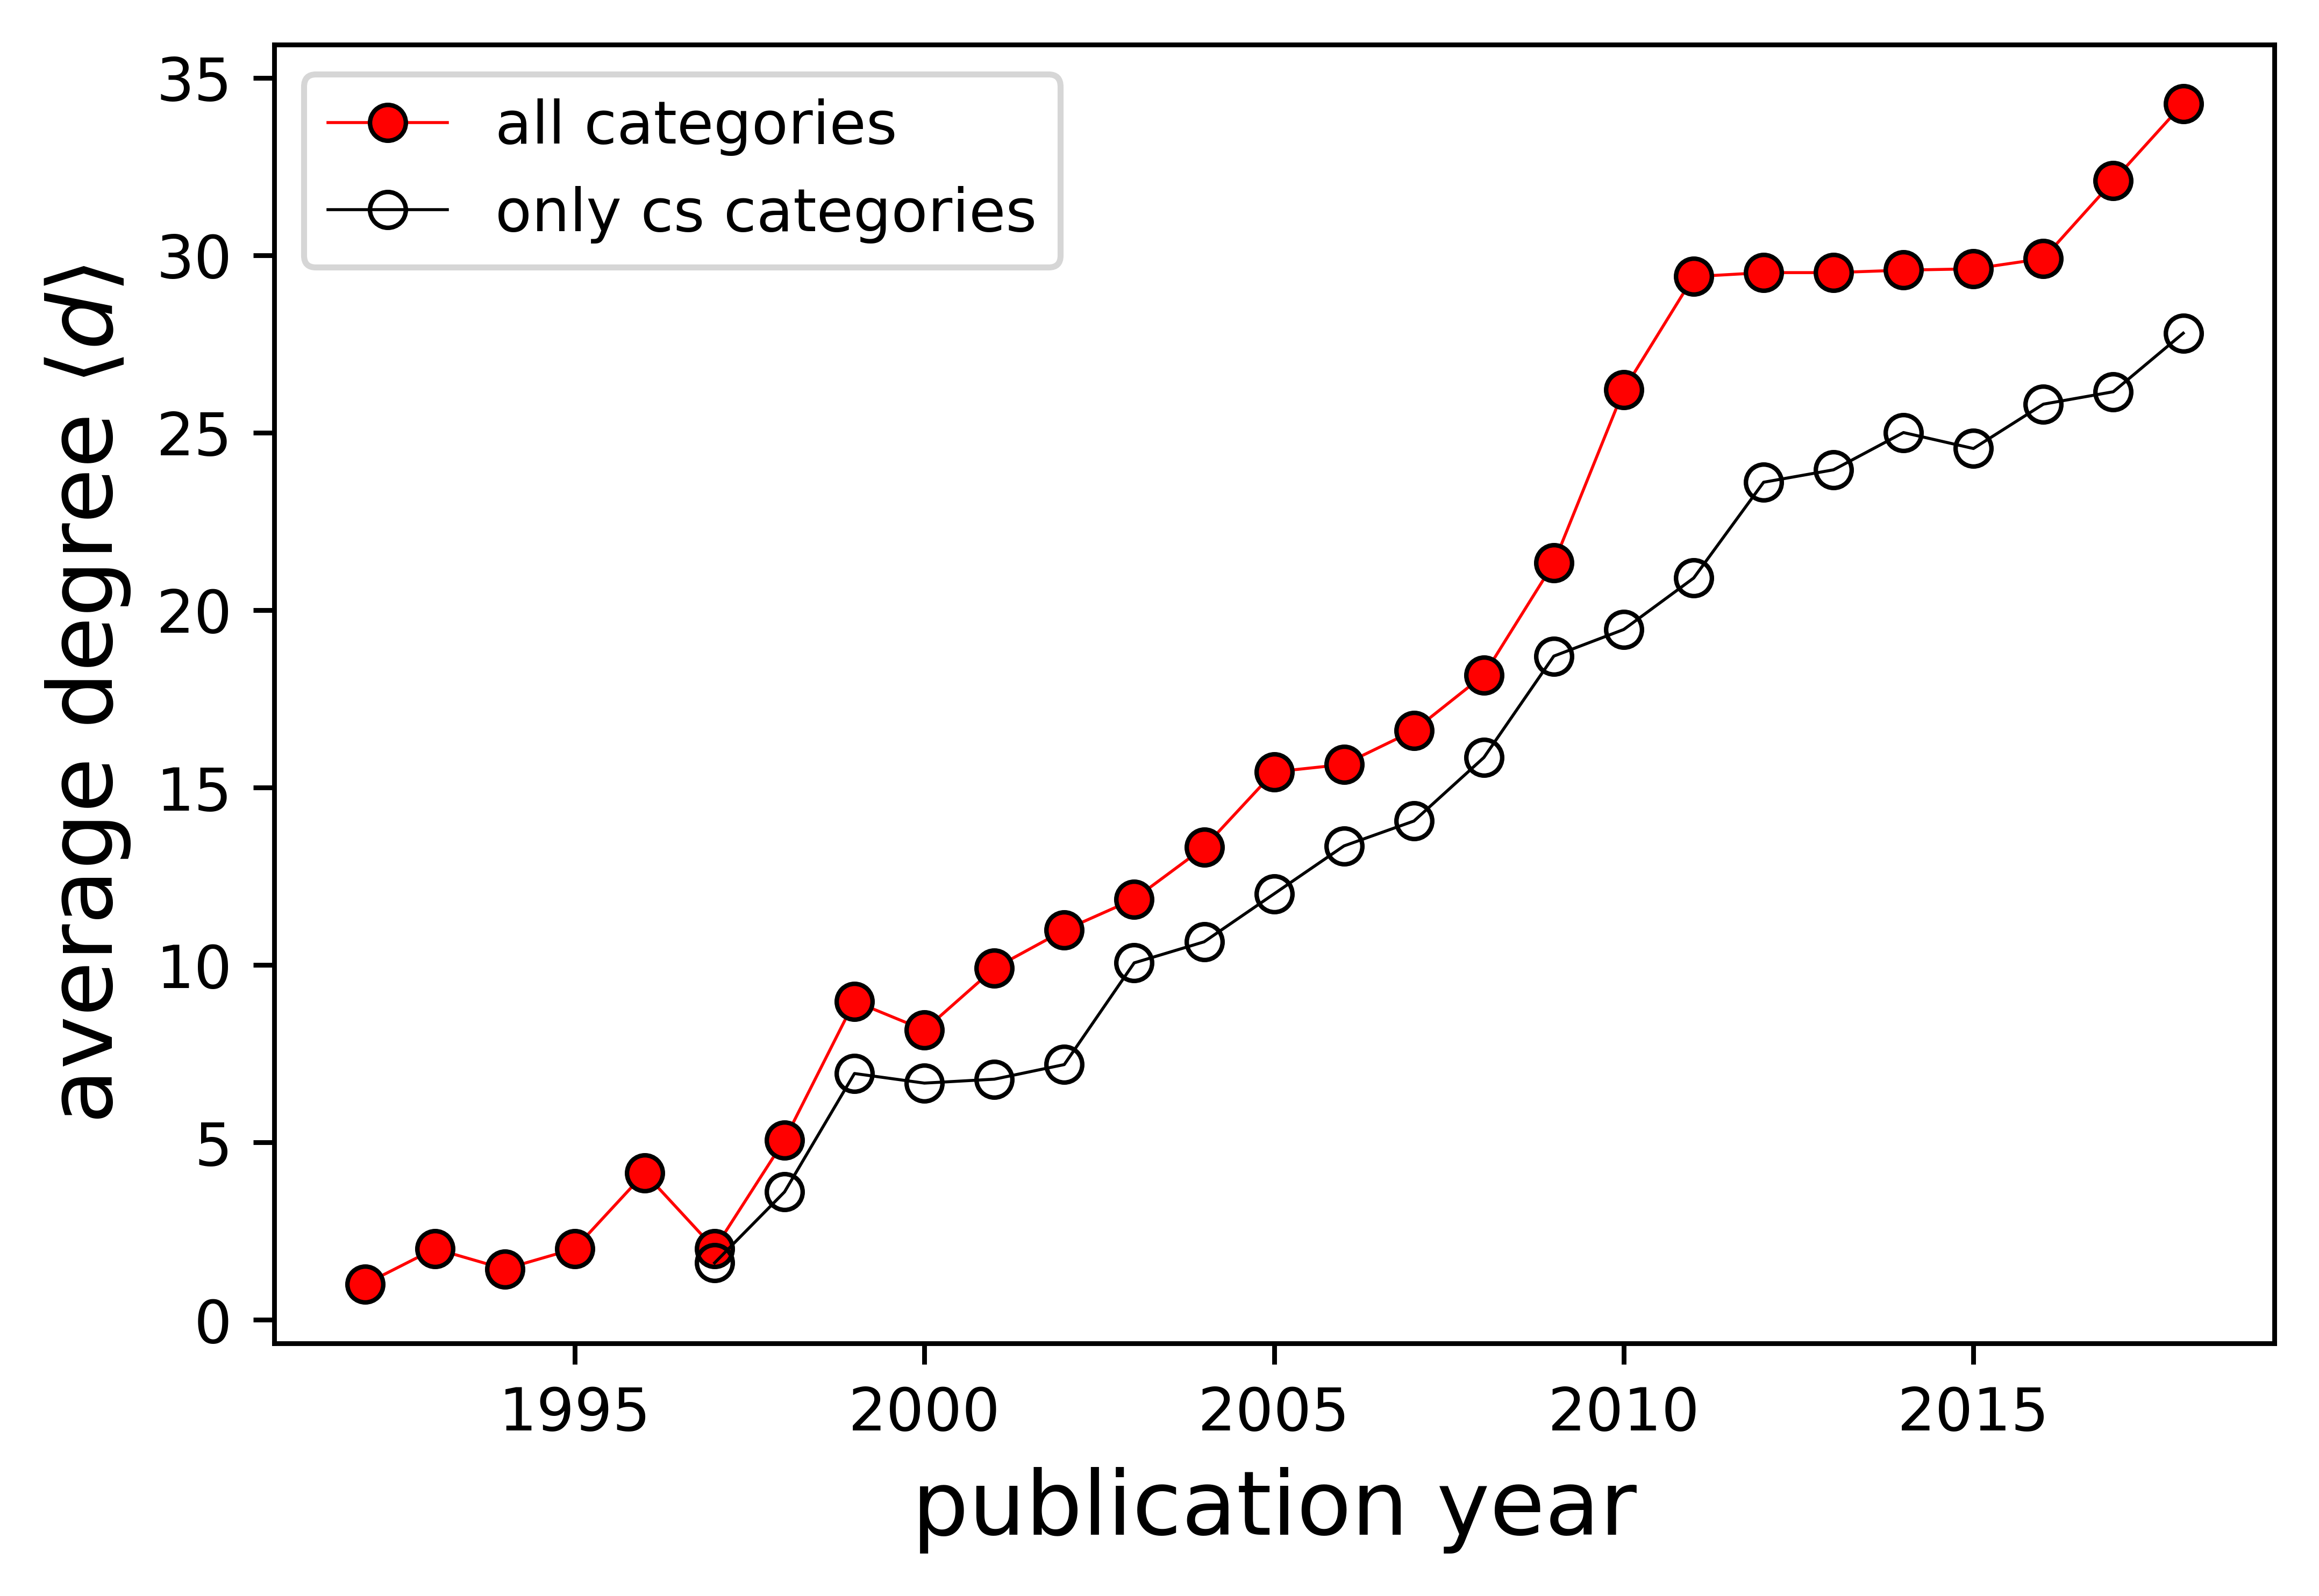

In [12]:
## plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=800)
ax.plot([int(y) for y in average_degree],list(average_degree.values()), 'r',marker='o',markeredgecolor='k',markersize=6,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='all categories')
ax.plot([int(y) for y in average_degree_cs],list(average_degree_cs.values()), 'k',marker='o',markeredgecolor='k',markersize=6,fillstyle='none',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='only cs categories')

ax.legend(loc='best')
ax.grid(False)
plt.ylabel(r'average degree $\langle d \rangle$',fontsize=15)
plt.xlabel(r'publication year',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('average_degree.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

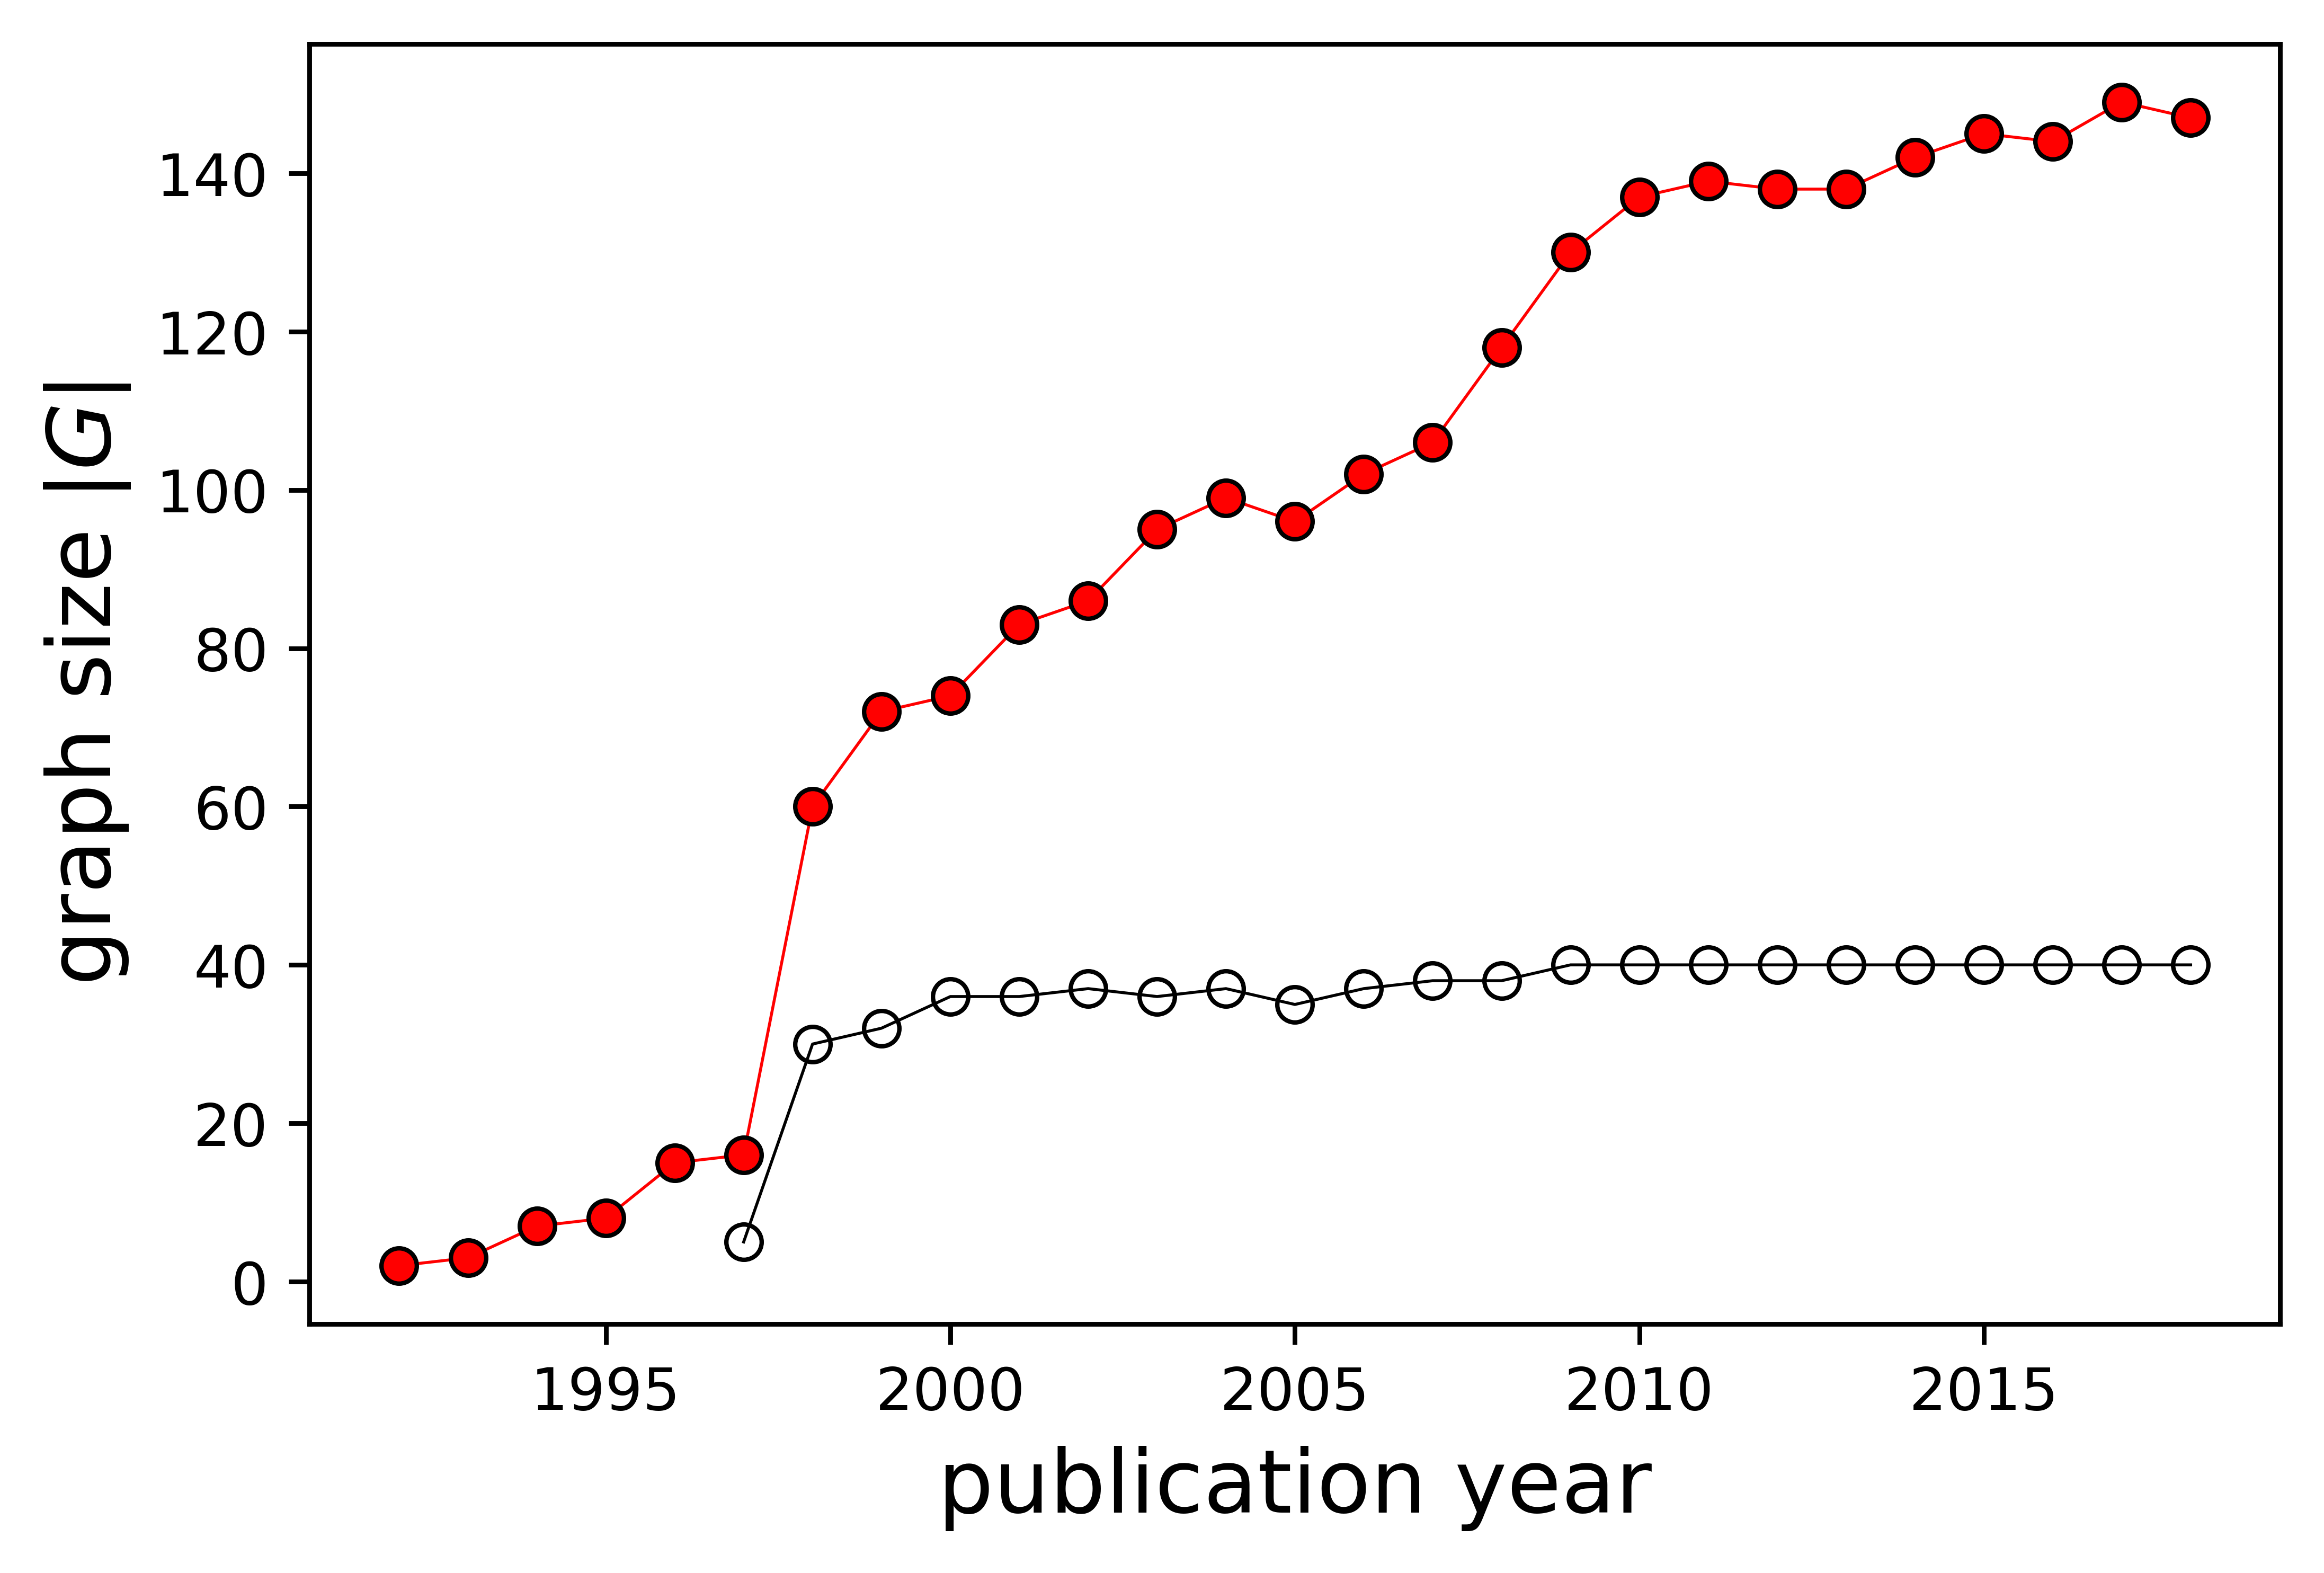

In [13]:
fig, ax = plt.subplots(dpi=800)
ax.plot([int(y) for y in average_degree],list(len_G.values()), 'r',marker='o',markeredgecolor='k',markersize=6,fillstyle='full',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='all categories')
ax.plot([int(y) for y in average_degree_cs],list(len_G_cs.values()), 'k',marker='o',markeredgecolor='k',markersize=6,fillstyle='none',markeredgewidth=.75,clip_on=True,linewidth=0.5,label='only cs categories')

#ax.legend(loc='best')
ax.grid(False)
plt.ylabel(r'graph size $|G|$',fontsize=15)
plt.xlabel(r'publication year',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('graph_len.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()